In [1]:
import pandas as pd

In [2]:
data_all=pd.read_csv(r'C:\Users\konto\atommi\selenium\data_all.csv')
data_all

,Title,Details
0,Bulgari Goes Green For Latest Jewelry Collection,FashionBulgari Goes Green For Latest Jewelry C...
1,Gucci's Grand Tour of New High Jewelry Collection,FashionGucci's Grand Tour of New High Jewelry ...
2,Best Jewelry from the Fall/Winter 2022 Runways,FashionBest Jewelry from the Fall/Winter 2022 ...
3,13 Men's Jewelry Pieces to Shop Now,Men's13 Men's Jewelry Pieces to Shop NowHere's...
4,How Male Celebs Wear Their Jewelry,FashionHow Male Celebs Wear Their JewelryJewel...
...,...,...
1466,Alicia Keys's Met Gala Hair Is Confusing and D...,"Have you ever seen Zendaya miss? Yeah, neither..."
1467,The Best Manicures and Nail Art at the BET Awards,Think of your ear as an empty canvas. With the...
1468,The Most Memorable Oscars Beauty Looks of All ...,"Ah, nipple piercings. So cute, yet so intimida..."
1469,This $135 Serum Is Literally Liquid Gold for Y...,"To me, tragus piercings always stood for colle..."


In [26]:
Details =data_all.drop(['Title'], axis=1)
Details

,Details
0,FashionBulgari Goes Green For Latest Jewelry C...
1,FashionGucci's Grand Tour of New High Jewelry ...
2,FashionBest Jewelry from the Fall/Winter 2022 ...
3,Men's13 Men's Jewelry Pieces to Shop NowHere's...
4,FashionHow Male Celebs Wear Their JewelryJewel...
...,...
1466,"Have you ever seen Zendaya miss? Yeah, neither..."
1467,Think of your ear as an empty canvas. With the...
1468,"Ah, nipple piercings. So cute, yet so intimida..."
1469,"To me, tragus piercings always stood for colle..."


In [34]:
Details['Details']= Details['Details'].astype(str)

In [19]:
%pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [22]:
import re
import spacy
from tqdm import tqdm
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string 
tqdm._instances.clear()

In [35]:
Details[Details['Details'].str.contains('FashionBulgari' and 'Green')]

,Details
0,FashionBulgari Goes Green For Latest Jewelry C...
9,FashionBulgari Goes Green For Latest Jewelry C...
18,FashionBulgari Goes Green For Latest Jewelry C...
27,FashionBulgari Goes Green For Latest Jewelry C...
36,FashionBulgari Goes Green For Latest Jewelry C...
...,...
1061,Our opportunities to experiment with style too...
1092,Statement earrings are always a good idea. But...
1123,I’m the type of gal who sticks to a few gold e...
1124,Our opportunities to experiment with style too...


In [36]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]   

In [37]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [49]:
[ent1,ent2] = get_entity("Prada has never done things by the book.")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("Prada has never done things by the book.")

Subj : Prada, obj : book


['Prada', 'book']

In [39]:
entity_pairs = []
for i in tqdm(Details['Details']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [01:52<00:00, 13.09it/s]


In [40]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]

In [59]:
def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",[pattern])
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text

In [61]:
get_entity("Prada has never done things by the book."), get_relation("Prada has never done things by the book.")

(['Prada', 'book'], 'done')

In [62]:
relations = [get_relation(i) for i in tqdm(Details['Details'])]
tqdm._instances.clear()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [01:56<00:00, 12.59it/s]


In [63]:
pd.Series(subjects).value_counts()[:10]

black fashion icon                                    279
much  we                                               77
formerly  She                                          46
Murdencelebrity beautyMarsai Murdencelebrity Guide     39
managing  She                                          28
dental Jaw care                                        27
Dolly  orders                                          25
When  she                                              21
StyleBy  These                                         20
QueenBy Elise Matching Suits                           20
dtype: int64

In [64]:
pd.Series(relations).value_counts()[:10]

saved                               234
is                                  172
are                                 107
take                                 43
2022FacebookTwitterPinterestSave     40
took                                 36
approaches                           31
retro                                31
gets                                 30
receive                              27
dtype: int64

In [65]:
def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp

In [67]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konto\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [68]:
preprocessed_sentences = [preprocess(i) for i in tqdm(Details['Details'])]
tqdm._instances.clear()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [03:04<00:00,  7.95it/s]


In [69]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [01:23<00:00, 17.63it/s]


In [70]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [01:10<00:00, 20.82it/s]


In [71]:
pd.Series(relations).value_counts()[:10]

2022facebooktwitterpinterestsave    117
goes                                 45
feel                                 44
take                                 44
met                                  41
pull                                 39
wear                                 38
saved                                38
think                                34
find                                 32
dtype: int64

In [72]:
entity_pairs2 = entity_pairs
relations2 = relations

In [73]:
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [00:00<00:00, 914860.79it/s]


In [74]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])


In [75]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(relations).value_counts()[:20])

###################  Most popular source entites    ###################### 
 original blackonblack fashion icon              279
best  bieber                                     39
daily beauty stories                             26
favorite contemporary jewelry labels             20
40 wardrobe staples                              20
christian musthaveby christian                   20
december editby inby nicole kliestfashionwhy     20
furious kesslerbeautyhailey bieber shares        20
10000  exhibitions                               20
december editby fall fashion trends              19
dtype: int64
###################  Most popular target entites    ###################### 
 major fall.11.30.2022 allison foster    279
allure instagram allure twitter          86
blue eyelinerby kiana murden             39
right  inbox                             30
talks organised base milano              20
size apple calin van paris               20
finally  satenstein                      20
40 ge

In [76]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df.head()
#MultiDIGRaph because its a directional graph

,source,target,edge
0,original blackonblack fashion icon,major fall.11.30.2022 allison foster,goes
1,original blackonblack fashion icon,major fall.11.30.2022 allison foster,collectionin
2,original blackonblack fashion icon,major fall.11.30.2022 allison foster,take
3,original blackonblack fashion icon,major fall.11.30.2022 allison foster,find
4,original blackonblack fashion icon,major fall.11.30.2022 allison foster,wear


In [79]:
knowledge_graph_df[knowledge_graph_df['source']==" fashion icon"]

,source,target,edge


In [80]:
G = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df['source']=="khan"],source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())

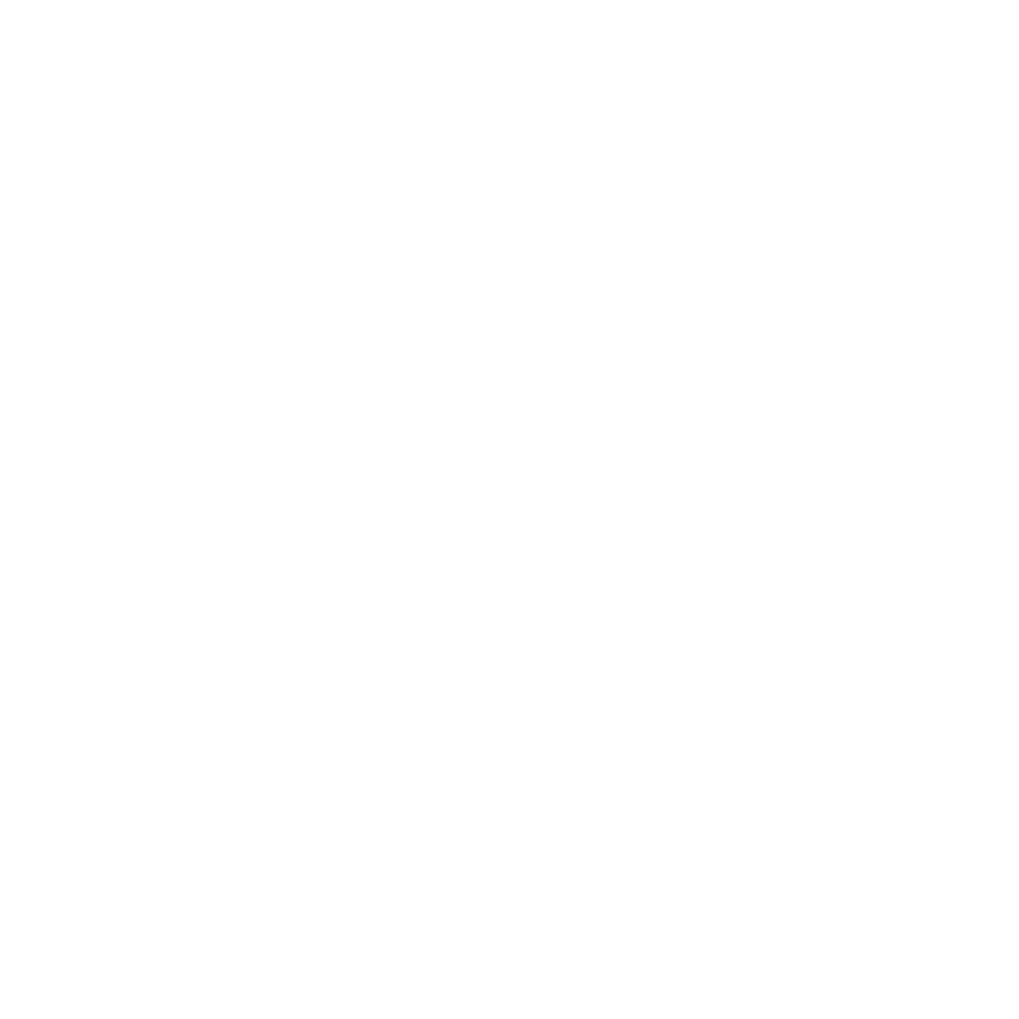

In [81]:
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()